# Modelling Phase and Results
## Notebook 4
###
####

### Imports and function initialisations

In [32]:
# to show images from folders:
from IPython.display import Image

# to hide all warnings:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# sklearn preprocessors and pipelines:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelBinarizer
from sklearn.compose import  make_column_transformer
from sklearn.pipeline import Pipeline


# sklearn models:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#sklearn metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_curve, auc

# yellowbrick's visualisations
from yellowbrick.classifier import PrecisionRecallCurve, ClassPredictionError

#needed in case
import importlib
from custom_functions import preprocessor, model_results_plots
importlib.reload(preprocessor)
importlib.reload(model_results_plots)

# from custom_functions directory inside preprocessor.py you can reference Preprocessor_function:
from custom_functions.preprocessor import Preprocessor_function


Below I import the custom functions:
- **multiclass_roc_auc_score_and_plot**
- **class_prediction_error_plot**
- **precision_recall_curve_plot**

To easily plot various metrics including ROC Curves, AUC scores etc.

In [35]:
# from custom_functions directory inside model_results_plots.py you can reference:
# -> multiclass_roc_auc_score_and_plot
# -> class_prediction_error_plot
# -> precision_recall_curve_plot

from custom_functions.model_results_plots \
    import multiclass_roc_auc_score_and_plot, class_prediction_error_plot, precision_recall_curve_plot, all_models_metrics

### Importing and splitting the dataset
Below I import the data and follow the splitting strategy that was mentioned in Notebook 3:

In [3]:
data = pd.read_csv('data_clean/for_models_dataset.csv')

X = data.drop(columns=['Customer_ID', 'Credit_Score'])
y = data['Credit_Score']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     random_state=42,
                     test_size=0.2,
                     stratify=y)

target_names = ['Good', 'Poor', 'Standard'] # needed for classification report

### Baseline Accuracy to be achieved by classifiers:

A way to calculate Baseline Accuracy is to use value_counts and max(). In other words, I calculate the relative frequencies of the unique values and then choose the maximum.

In [4]:
print(f"Baseline accuracy: {y_train.value_counts(normalize=True).max()*100:.2f}%\n\n")

baseline_accuracy = y_train.value_counts(normalize=True)
print(f"Baseline accuracy (class: Standard): {baseline_accuracy.iloc[0]*100:.2f}%")
print(f"Baseline accuracy (class: Poor): {baseline_accuracy.iloc[1]*100:.2f}%")
print(f"Baseline accuracy (class: Good): {baseline_accuracy.iloc[2]*100:.2f}%")

Baseline accuracy: 51.88%


Baseline accuracy (class: Standard): 51.88%
Baseline accuracy (class: Poor): 28.82%
Baseline accuracy (class: Good): 19.30%


The baseline accuracy should be the minimum accuracy achieved by the created classifier. In my case, I should achieve an accuracy equal or greater than **51.88%**.

#### Creating column transformers with the Preprocessor_function
Refer to **notebook 2** to understand why I include the features:
- **Credit_Utilization_Ratio**
- **Occupation**
- **Payment_Behaviour**
into the **excluded_features** list. 

In [5]:
excluded_features = ['Customer_ID', 'Credit_Utilization_Ratio', 'Occupation', 'Payment_Behaviour']
pr_oh = \
    Preprocessor_function(data = data,
                          target_variable = 'Credit_Score',
                          cat_encoder = 'oh',
                          excluded_features = excluded_features
                          ).fit(data)


pr_ord = \
    Preprocessor_function(data = data,
                          target_variable = 'Credit_Score',
                          cat_encoder = 'ord',
                          excluded_features = excluded_features
                          ).fit(data)

pr_oh

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['Age', 'Annual_Income', 'Outstanding_Debt',
                                  'Total_EMI_per_month', 'Delay_from_due_date',
                                  'Num_of_Delayed_Payment']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['Credit_Mix', 'Payment_of_Min_Amount'])])

### Initial Models
Below I create a pipeline with a **simple Logistic Regression Classifier**:

              precision    recall  f1-score   support

        Good       0.50      0.51      0.51       483
        Poor       0.54      0.35      0.42       720
    Standard       0.59      0.70      0.64      1297

    accuracy                           0.56      2500
   macro avg       0.54      0.52      0.52      2500
weighted avg       0.56      0.56      0.55      2500


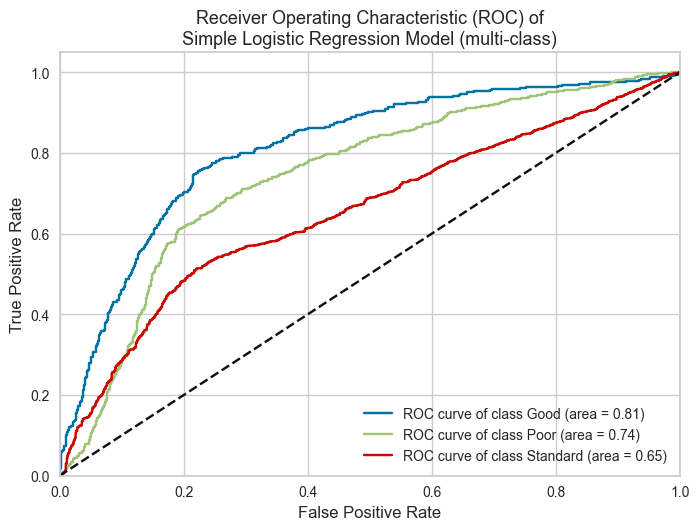

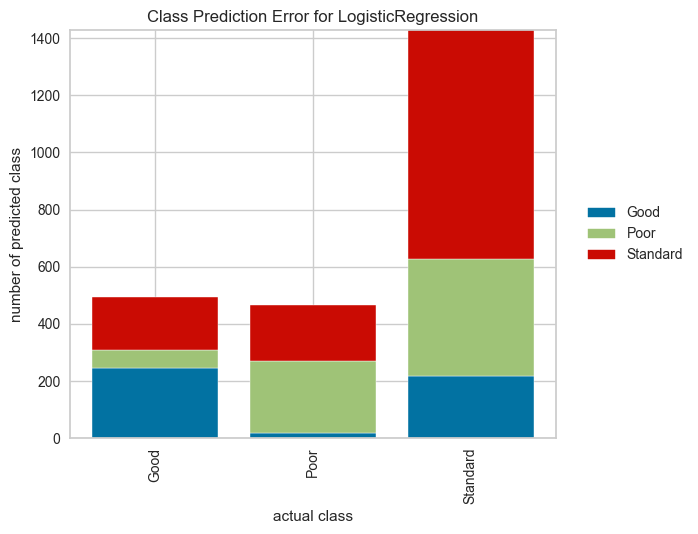

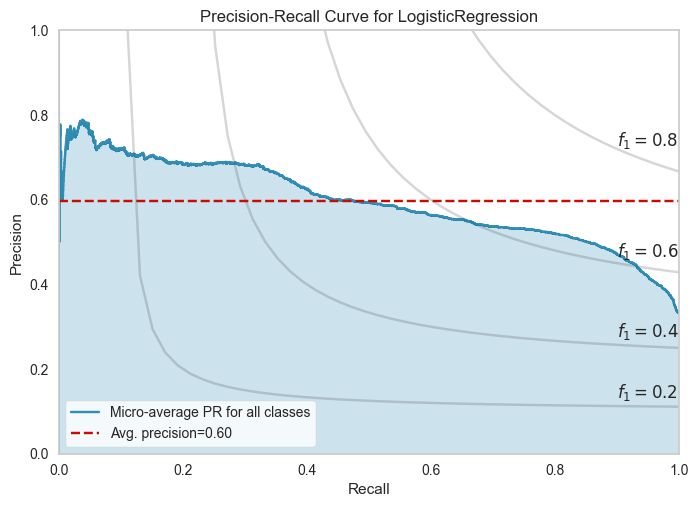

In [6]:
model_lr = \
Pipeline([
    ('preprocessor',pr_oh),
    ('estimator', LogisticRegression(multi_class='multinomial', random_state=42))
])

model_lr.fit(X_train, y_train)


print(classification_report(y_test, model_lr.predict(X_test),
                            target_names=target_names))

auc_scores_simple_lr = multiclass_roc_auc_score_and_plot(model_lr, X_test, y_test, model_name='Simple Logistic Regression')

class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = model_lr,
                            is_fitted = True);



precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = model_lr,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Below I create a pipeline with a **simple KNN Classifier**:

              precision    recall  f1-score   support

        Good       0.50      0.51      0.50       483
        Poor       0.57      0.53      0.55       720
    Standard       0.63      0.66      0.65      1297

    accuracy                           0.59      2500
   macro avg       0.57      0.56      0.57      2500
weighted avg       0.59      0.59      0.59      2500


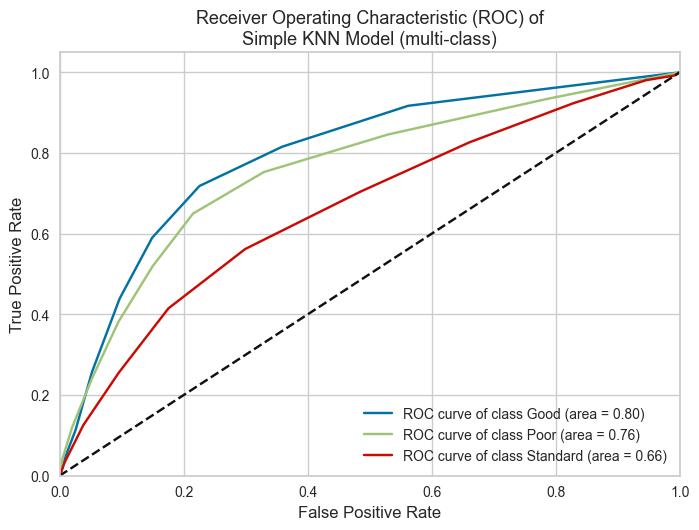

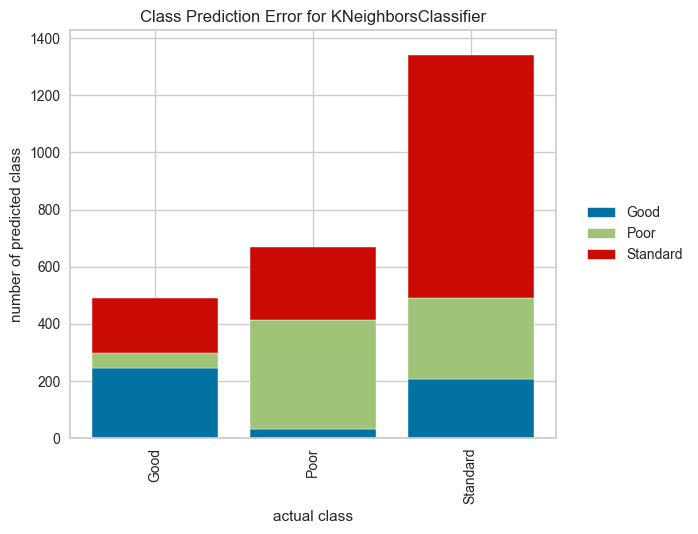

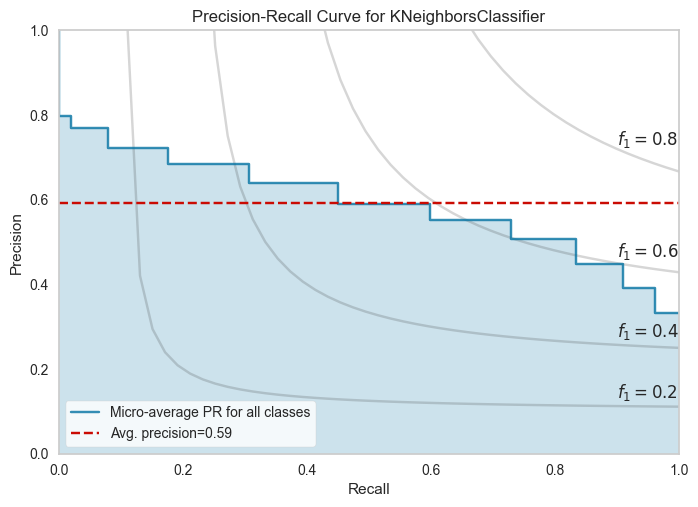

In [7]:
model_knn = \
    Pipeline([
        ('preprocessor',pr_oh),
        ('estimator', KNeighborsClassifier(n_neighbors=10))
    ])

model_knn.fit(X_train, y_train)


print(classification_report(y_test, model_knn.predict(X_test),
                            target_names=target_names))

auc_scores_simple_knn = multiclass_roc_auc_score_and_plot(model_knn, X_test, y_test, model_name='Simple KNN')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = model_knn,
                            is_fitted = True);



precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = model_knn,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Below I create a pipeline with a **simple Decision Tree Classifier**:

              precision    recall  f1-score   support

        Good       0.38      0.40      0.39       483
        Poor       0.46      0.45      0.45       720
    Standard       0.58      0.57      0.57      1297

    accuracy                           0.50      2500
   macro avg       0.47      0.47      0.47      2500
weighted avg       0.50      0.50      0.50      2500


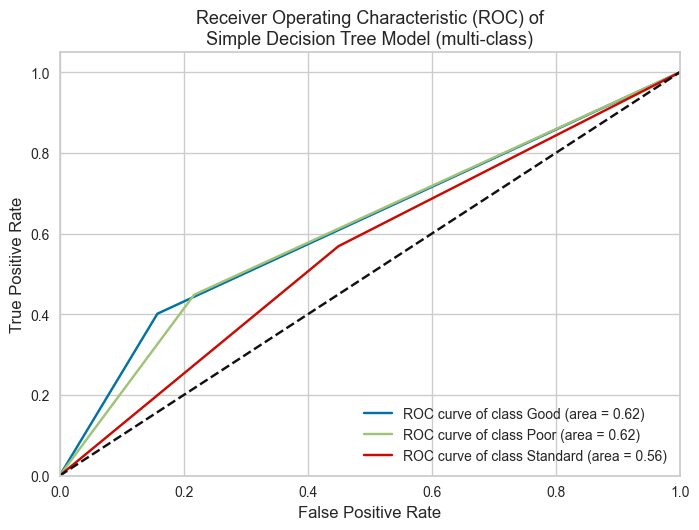

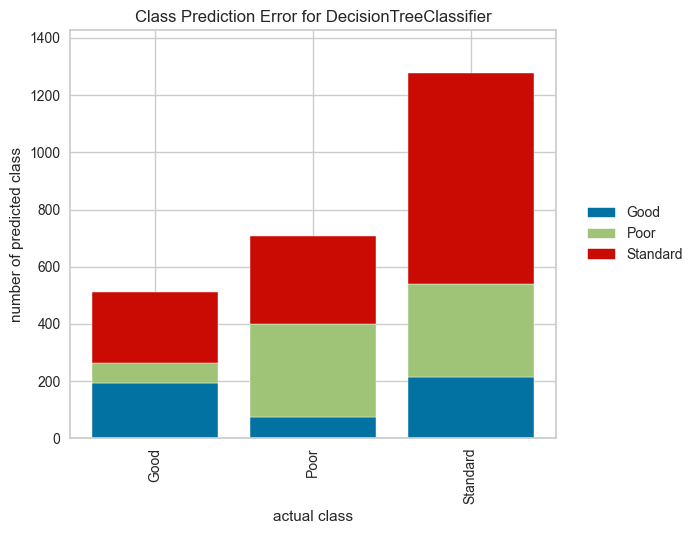

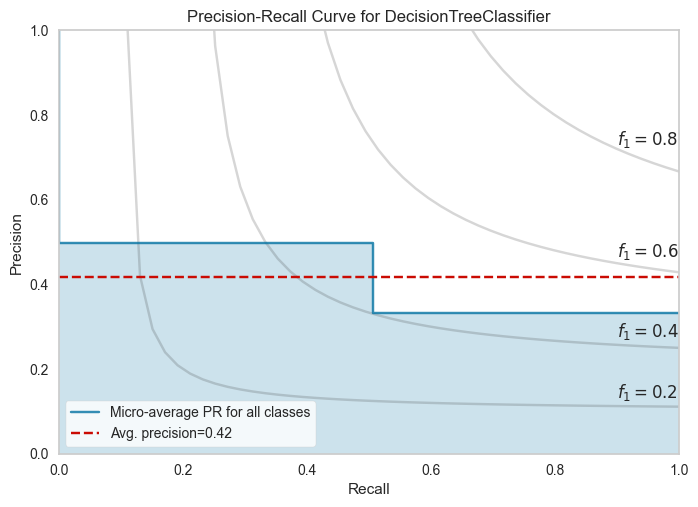

In [8]:
model_dtr = \
    Pipeline([
        ('preprocessor',pr_ord),
        ('estimator', DecisionTreeClassifier(random_state=42))
    ])

model_dtr.fit(X_train, y_train)


print(classification_report(y_test, model_dtr.predict(X_test),
                            target_names=target_names))

auc_scores_simple_dtr = multiclass_roc_auc_score_and_plot(model_dtr, X_test, y_test, model_name='Simple Decision Tree')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = model_dtr,
                            is_fitted = True);



precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = model_dtr,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Below I create a pipeline with a **simple SVM Classifier**:
**Important Note**: For SVM Classifiers I will keep the maximum threshold iterations to 10000.

              precision    recall  f1-score   support

        Good       0.48      0.62      0.54       483
        Poor       0.61      0.56      0.59       720
    Standard       0.67      0.63      0.65      1297

    accuracy                           0.61      2500
   macro avg       0.59      0.60      0.59      2500
weighted avg       0.62      0.61      0.61      2500


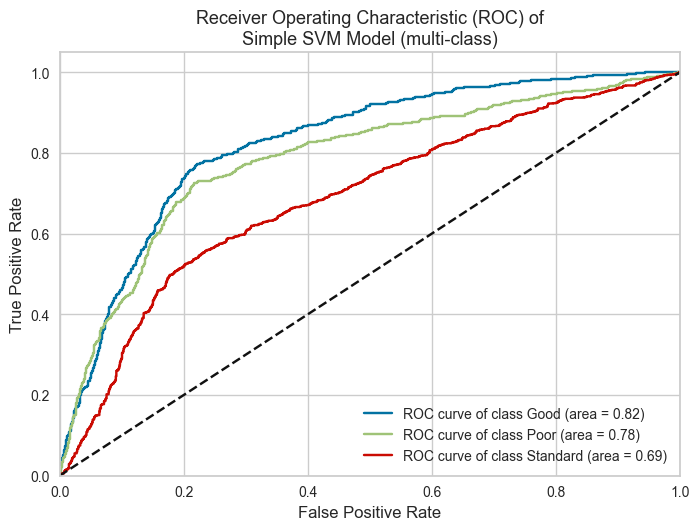

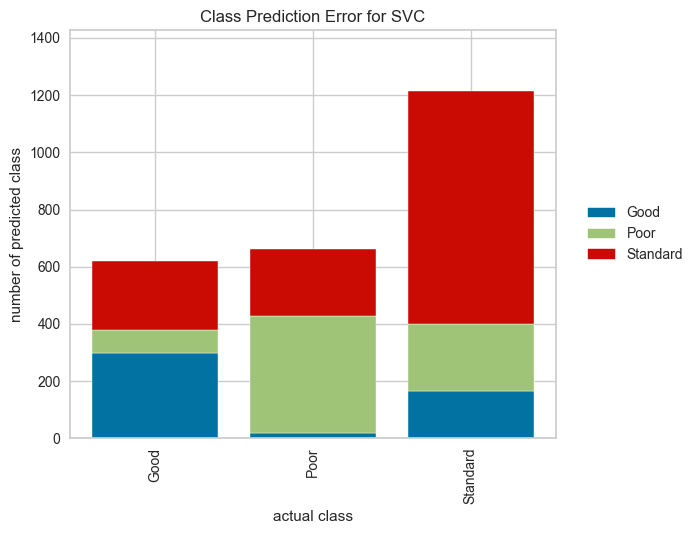

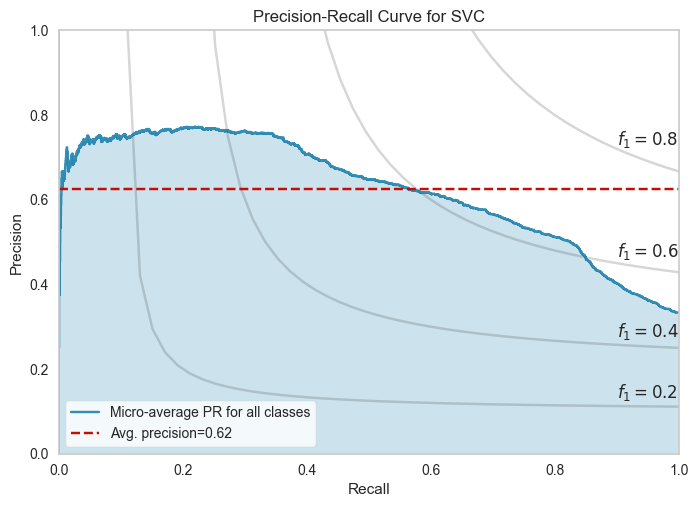

In [9]:
model_svm = \
    Pipeline([
        ('preprocessor',pr_oh),
        ('estimator', SVC(random_state= 42,
                          probability= True,
                          coef0= 1,
                          max_iter= 10_000
                         ) )
    ])

model_svm.fit(X_train, y_train)


print(classification_report(y_test, model_svm.predict(X_test),
                            target_names= target_names))

auc_scores_simple_svm = multiclass_roc_auc_score_and_plot(model_svm, X_test, y_test, model_name='Simple SVM')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = model_svm,
                            is_fitted = True);



precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = model_svm,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

#### Using GridSearchCV with the above Classifiers

The [**scoring metrics**](https://scikit-learn.org/stable/modules/model_evaluation.html) I can use on **GridSearchCV** are demonstrated below. I will use ROC curves and AUC score to evaluate my initial models. 

**I choose AUC score for the reasons below**:
- AUC score helps us understand how well the model is able to distinguish between classes at different cutoff levels.
- The AUC gives higher value to correctly classified instances. The **higher the AUC**, the **better the model's performance** in distinguishing between classes.
- The AUC is a useful metric for **imbalanced classes**.
- AUC delivers a performance metric which is effectively a rank-based measure of performance, and as such, it isn't sensitive to the scale of predicted probabilities. Whether my classifier delivers probabilities between 0.1 and 0.5, or 0.9 and 1, won't in itself affect the AUC.

Scoring Metrics available


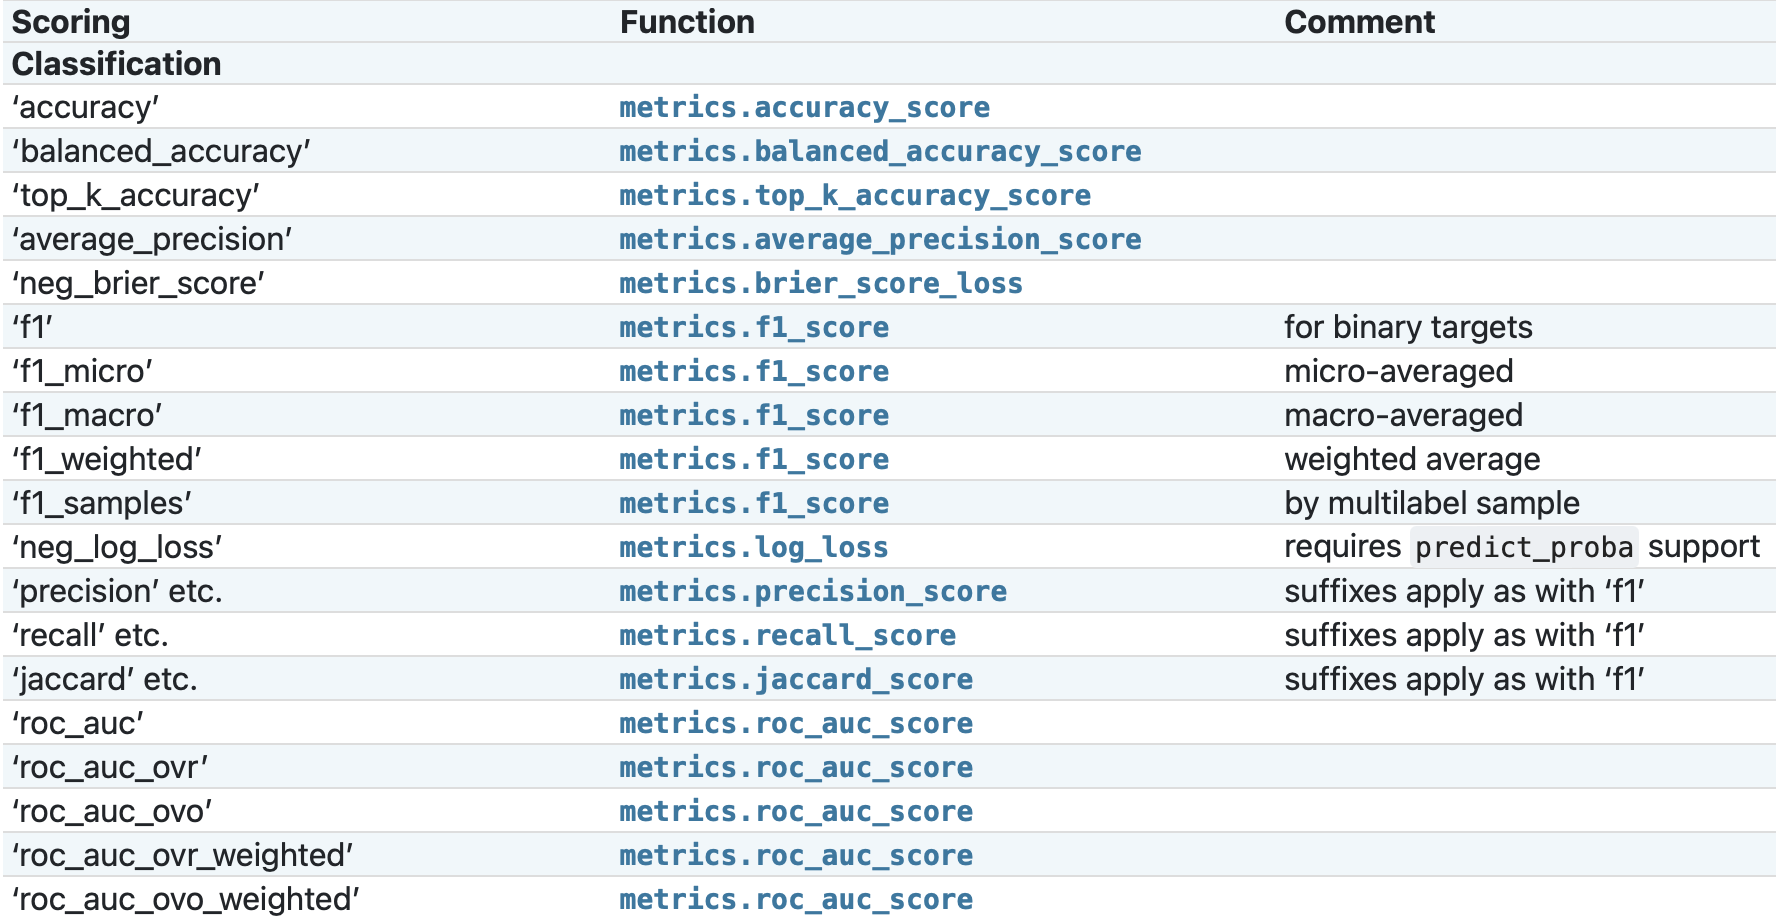

In [10]:
# The score to be used on Grid Searchers:
score_metric_used = 'roc_auc_ovr'

print('Scoring Metrics available')
Image("images/scoring_metrics.png")

Below I use the GridSearchCV on **Logistic Regression** Pipeline:

In [11]:
lr_params = {'estimator__C':[0.1,1,10,100,150,200,250,300,500,1000],
             'estimator__max_iter':[300, 1000, 10000]
             }

grid_lr = \
    GridSearchCV(estimator= model_lr,
                 param_grid= lr_params,
                 scoring= score_metric_used,
                 return_train_score= True
                 ).fit(X_train, y_train)

And I plot/export the metrics below:

              precision    recall  f1-score   support

        Good       0.50      0.51      0.51       483
        Poor       0.54      0.35      0.42       720
    Standard       0.59      0.70      0.64      1297

    accuracy                           0.56      2500
   macro avg       0.54      0.52      0.52      2500
weighted avg       0.56      0.56      0.55      2500


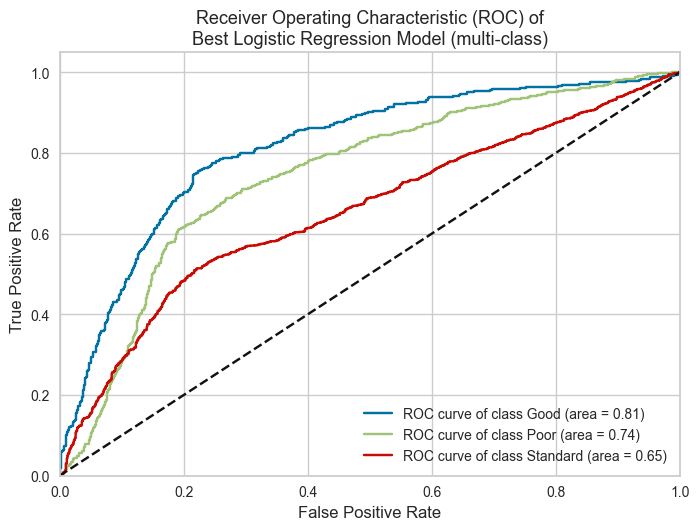

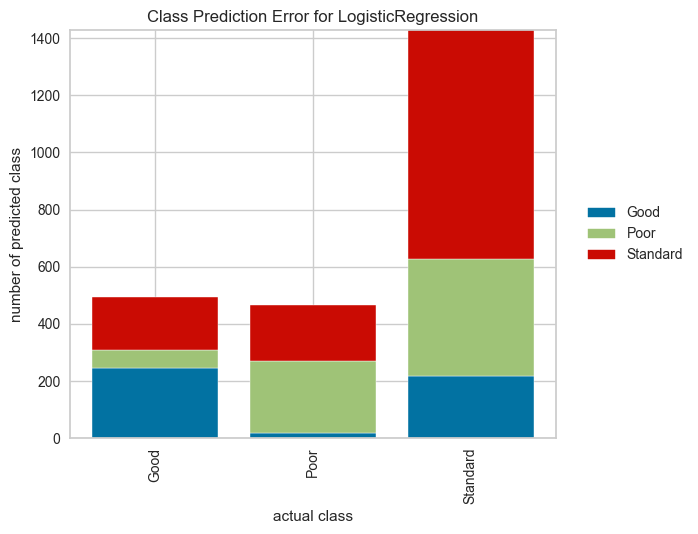

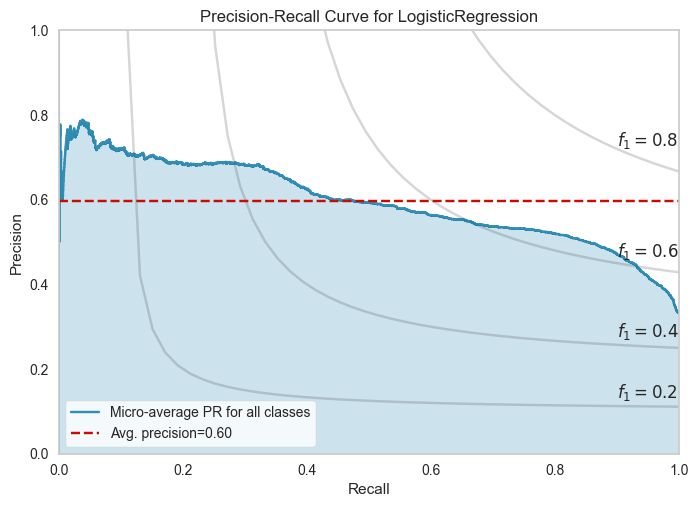

In [12]:
print(classification_report(y_test,
                            grid_lr.best_estimator_.predict(X_test),
                            target_names=target_names)
      )

auc_scores_lr = multiclass_roc_auc_score_and_plot(grid_lr.best_estimator_,
                                               X_test, y_test,
                                               model_name='Best Logistic Regression')

class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_lr.best_estimator_,
                            is_fitted = True);

precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_lr.best_estimator_,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Below I use the GridSearchCV on **KNN** Pipeline:

**Note**: [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics) of available metrics to check.

In [13]:
knn_params = {'estimator__n_neighbors':[3, 5, 7, 19],
             'estimator__weights':['uniform', 'distance'],
              'estimator__metric':['minkowski','euclidean','manhattan','cosine']
             }

grid_knn = \
    GridSearchCV(estimator= model_knn,
                 param_grid= knn_params,
                 scoring= score_metric_used,
                 return_train_score= True,
                 n_jobs = 4
                 ).fit(X_train, y_train)

And I plot/export the metrics below:

              precision    recall  f1-score   support

        Good       0.51      0.48      0.50       483
        Poor       0.62      0.51      0.56       720
    Standard       0.64      0.71      0.67      1297

    accuracy                           0.61      2500
   macro avg       0.59      0.57      0.58      2500
weighted avg       0.61      0.61      0.61      2500


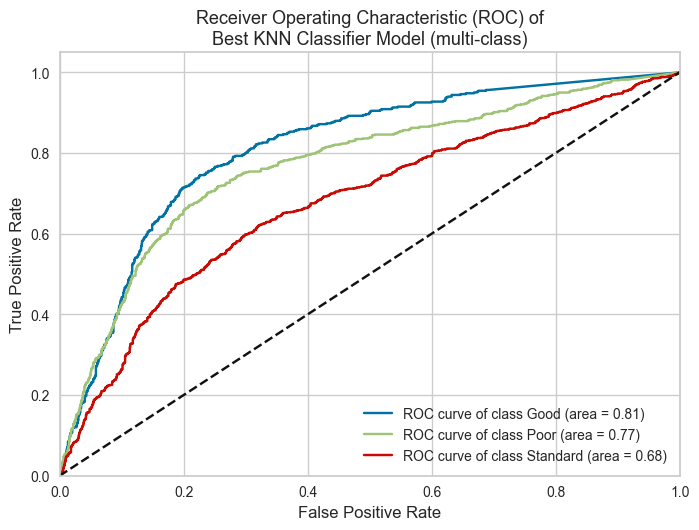

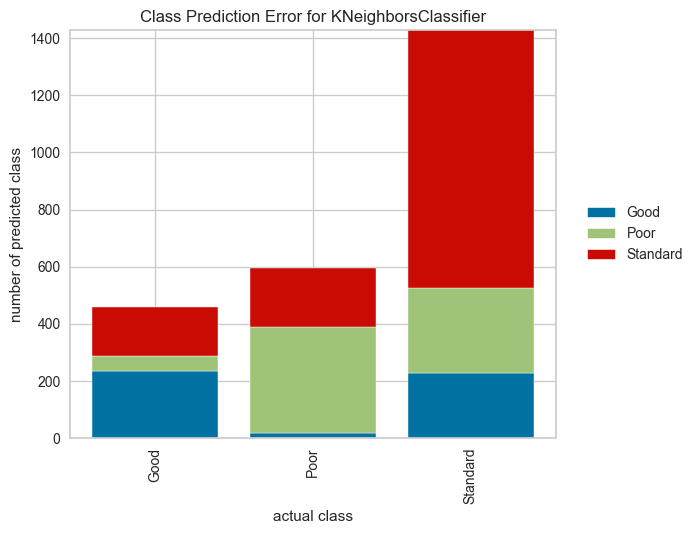

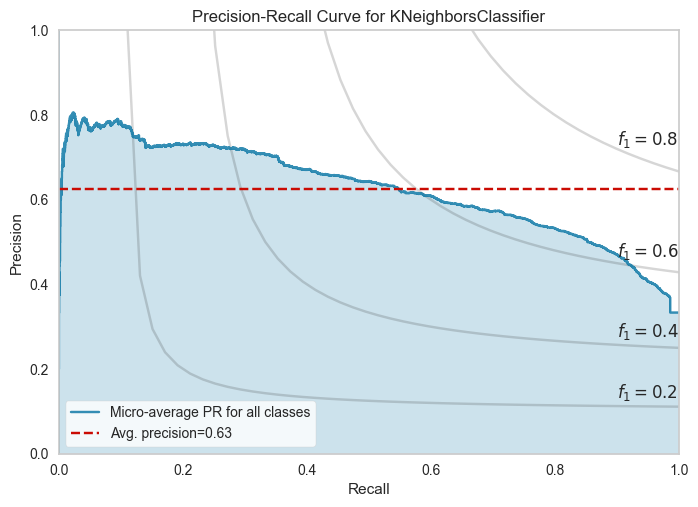

In [14]:
print(classification_report(y_test, grid_knn.best_estimator_.predict(X_test),
                            target_names=target_names)
      )


auc_scores_knn = multiclass_roc_auc_score_and_plot(grid_knn.best_estimator_,
                                               X_test, y_test,
                                               model_name='Best KNN Classifier')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_knn.best_estimator_,
                            is_fitted = True);

precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_knn.best_estimator_,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Below I use the GridSearchCV on **Decision Tree** Pipeline:

In [15]:
dtr_params = {'estimator__criterion':['gini', 'entropy', 'log_loss'],
              'estimator__splitter':['best', 'random'],
              'estimator__min_samples_split':[2,4,6],
              'estimator__min_samples_leaf':[1,2,3,4,5],
              'estimator__max_features':[None, 'sqrt', 'log2'],
              'estimator__max_depth':[None,3, 10, 20 ,30, 100]
              }

grid_dtr = \
    GridSearchCV(estimator= model_dtr,
                 param_grid= dtr_params,
                 scoring= score_metric_used,
                 return_train_score= True,
                 n_jobs = 4
                 ).fit(X_train, y_train)

And I plot/export the metrics below:

              precision    recall  f1-score   support

        Good       0.48      0.68      0.56       483
        Poor       0.61      0.54      0.57       720
    Standard       0.69      0.62      0.65      1297

    accuracy                           0.61      2500
   macro avg       0.59      0.61      0.60      2500
weighted avg       0.62      0.61      0.61      2500


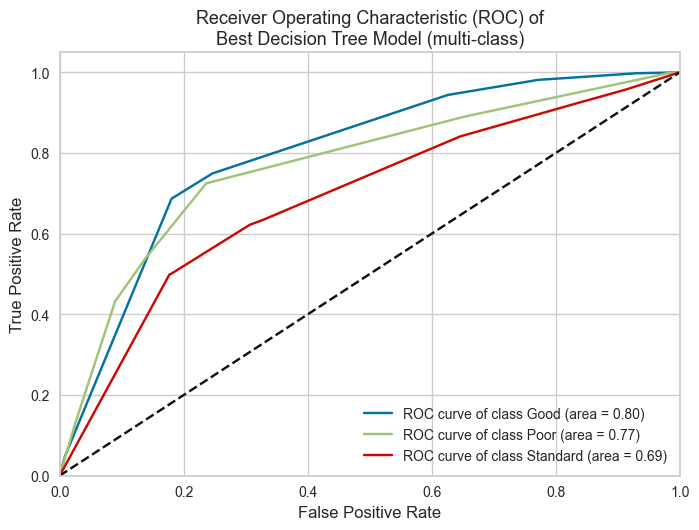

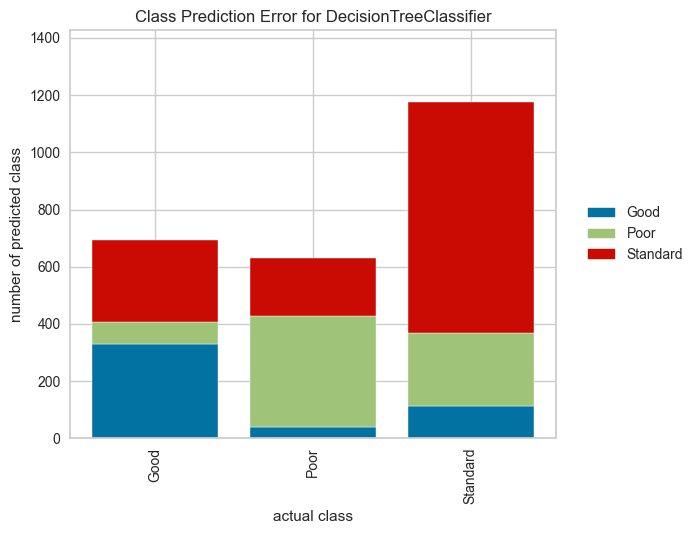

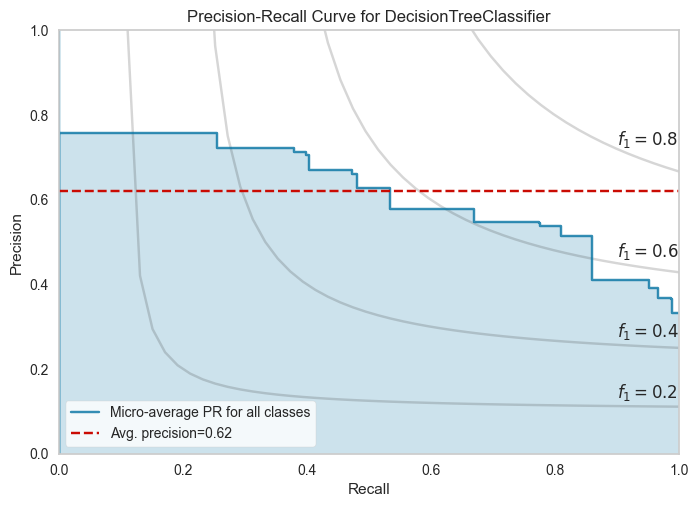

In [16]:
print(classification_report(y_test, grid_dtr.best_estimator_.predict(X_test),
                            target_names=target_names)
      )


auc_scores_dtr = multiclass_roc_auc_score_and_plot(grid_dtr.best_estimator_,
                                               X_test, y_test,
                                               model_name='Best Decision Tree')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_dtr.best_estimator_,
                            is_fitted = True);

precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_dtr.best_estimator_,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);


Below I use the GridSearchCV on **SVM** Pipeline:

In [17]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

svm_params = {'estimator__C':[1, 10, 100],
              'estimator__kernel':['rbf', 'linear', 'poly', 'sigmoid'],
              'estimator__gamma':['scale','auto'],
              'estimator__class_weight':[None, 'balanced']
              }

grid_svm = \
    GridSearchCV(estimator= model_svm,
                 param_grid= svm_params,
                 scoring= score_metric_used,
                 return_train_score= True,
                 cv = 2, # because of computational restrictions on my local machine I set the cv = 2
                 n_jobs = 4
                 ).fit(X_train, y_train)

# Produces warnings because of max_iter =  10_000. 
# Unfortunately, I cannot change this setting due to computational constraints of my local machine.

And I plot/export the metrics below:

              precision    recall  f1-score   support

        Good       0.47      0.75      0.58       483
        Poor       0.58      0.70      0.63       720
    Standard       0.75      0.50      0.60      1297

    accuracy                           0.60      2500
   macro avg       0.60      0.65      0.60      2500
weighted avg       0.65      0.60      0.60      2500


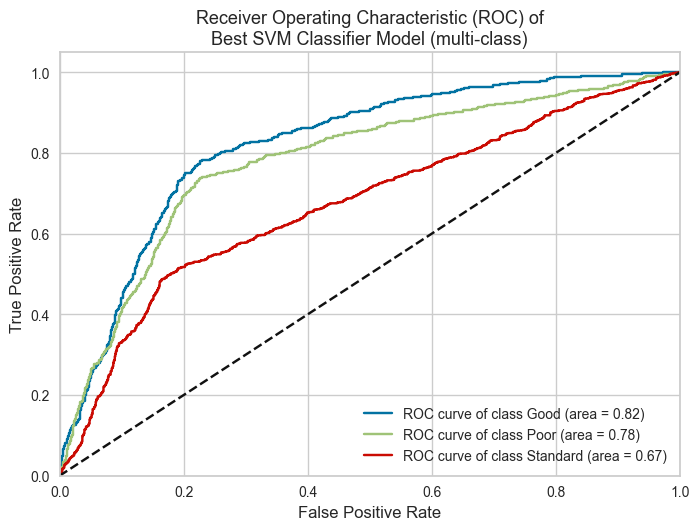

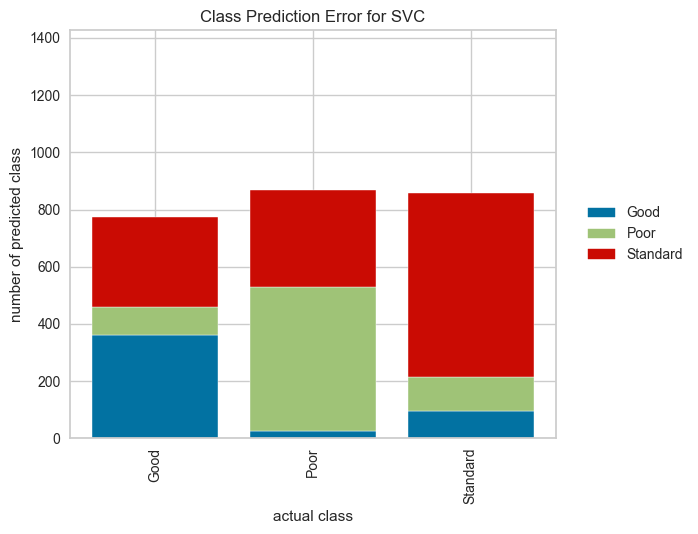

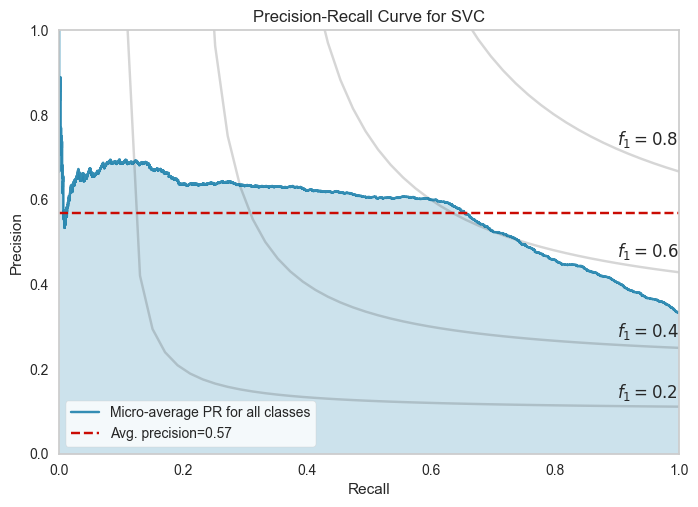

In [18]:
print(classification_report(y_test, grid_svm.best_estimator_.predict(X_test),
                            target_names=target_names)
      )


auc_scores_svm = multiclass_roc_auc_score_and_plot(grid_svm.best_estimator_,
                                                   X_test, y_test,
                                                   model_name='Best SVM Classifier')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_svm.best_estimator_,
                            is_fitted = True);

precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_svm.best_estimator_,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

### Additional Models

I add some extra models to the analysis. More specifically, I will use:
- **Random Forest Classifier**
- **Gradient Boosting Classifier**

In [19]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

Below, I create a pipeline with a **simple Random Forest Classifier**:

              precision    recall  f1-score   support

        Good       0.50      0.48      0.49       483
        Poor       0.60      0.57      0.59       720
    Standard       0.64      0.67      0.65      1297

    accuracy                           0.60      2500
   macro avg       0.58      0.57      0.58      2500
weighted avg       0.60      0.60      0.60      2500


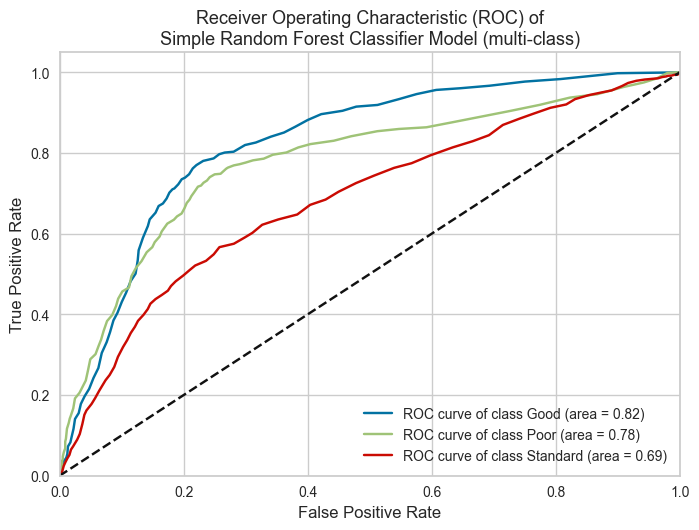

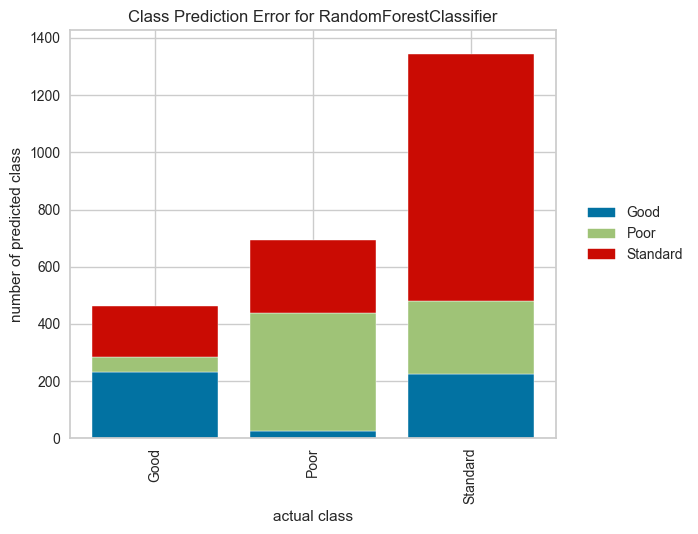

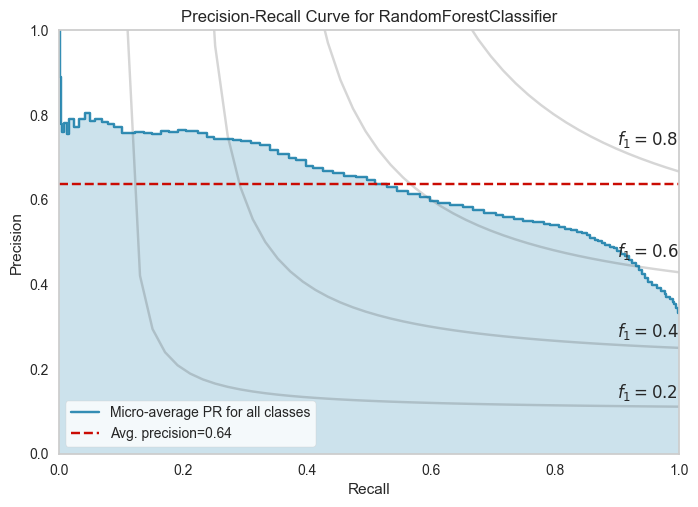

In [20]:
model_ranf = \
    Pipeline([
        ('preprocessor',pr_ord), # it uses tree models, so I do not use One Hot Encoding
        ('estimator', RandomForestClassifier(random_state= 42, oob_score = False) )
    ])

model_ranf.fit(X_train, y_train)


print(classification_report(y_test, model_ranf.predict(X_test),
                            target_names= target_names))

auc_scores_simple_ranf = multiclass_roc_auc_score_and_plot(model_ranf,
                                                           X_test, y_test,
                                                           model_name='Simple Random Forest Classifier')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = model_ranf,
                            is_fitted = True);



precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = model_ranf,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Below, I create a pipeline with a **simple Gradient Boosting Classifier**:

              precision    recall  f1-score   support

        Good       0.51      0.53      0.52       483
        Poor       0.61      0.58      0.60       720
    Standard       0.66      0.67      0.66      1297

    accuracy                           0.62      2500
   macro avg       0.59      0.59      0.59      2500
weighted avg       0.62      0.62      0.62      2500


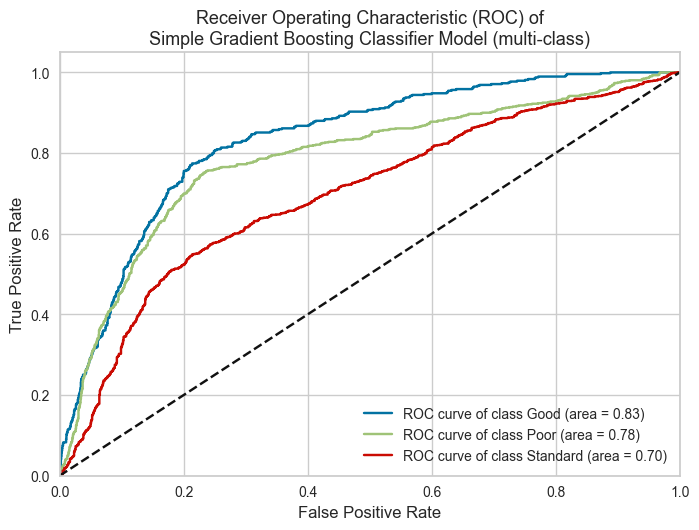

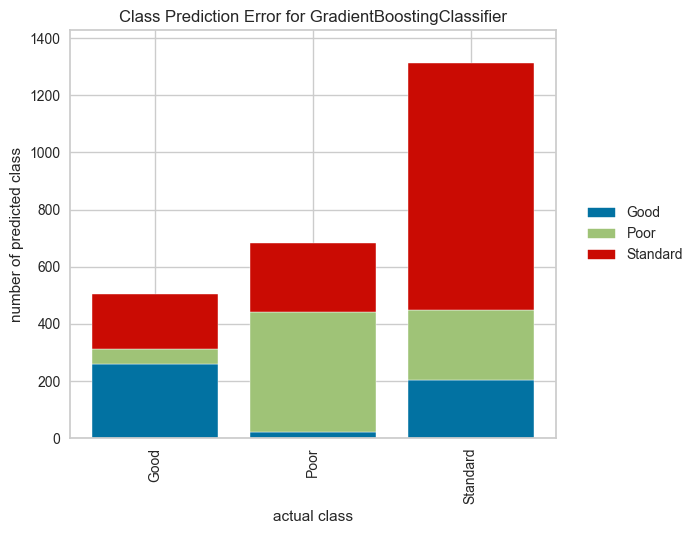

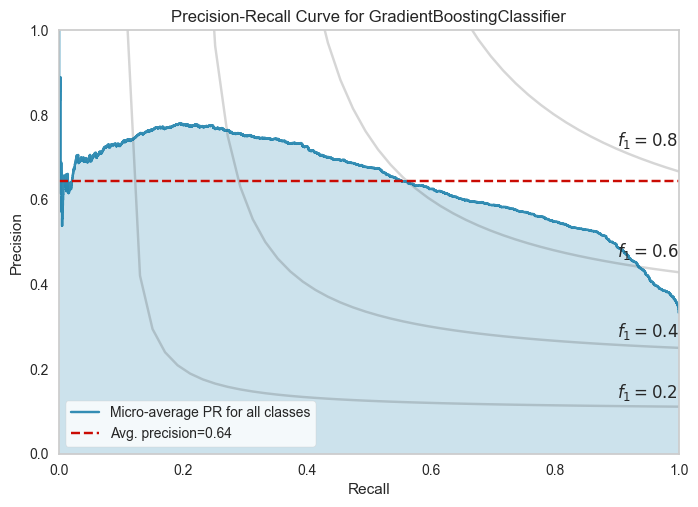

In [21]:
model_gbc = \
    Pipeline([
        ('preprocessor',pr_ord), # it uses tree models, so I do not use One Hot Encoding
        ('estimator', GradientBoostingClassifier(random_state= 42) )
    ])

model_gbc.fit(X_train, y_train)


print(classification_report(y_test, model_gbc.predict(X_test),
                            target_names= target_names))

auc_scores_simple_gbc = multiclass_roc_auc_score_and_plot(model_gbc,
                                                          X_test, y_test,
                                                          model_name= 'Simple Gradient Boosting Classifier')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = model_gbc,
                            is_fitted = True);



precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = model_gbc,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

#### Using GridSearchCV on the above models

Below I use the GridSearchCV on **Random Forest Classifier** Pipeline:

In [22]:
ranf_params = {'estimator__n_estimators':[1, 10, 100],
              'estimator__criterion':['gini', 'entropy'],
              #'estimator__ccp_alpha': [0.0, 0.05, 0.2], # commented to reduce the dimensions of param_grid
              'estimator__max_features':[None, 'sqrt', 'log2'],
              'estimator__max_depth':[3, 10, 20]
              }

grid_ranf = \
    GridSearchCV(estimator= model_ranf,
                 param_grid= ranf_params,
                 scoring= score_metric_used,
                 return_train_score= True,
                 n_jobs = 4
                 ).fit(X_train, y_train)

And I plot/export the metrics below:

              precision    recall  f1-score   support

        Good       0.51      0.63      0.56       483
        Poor       0.62      0.59      0.60       720
    Standard       0.69      0.64      0.66      1297

    accuracy                           0.62      2500
   macro avg       0.60      0.62      0.61      2500
weighted avg       0.63      0.62      0.63      2500


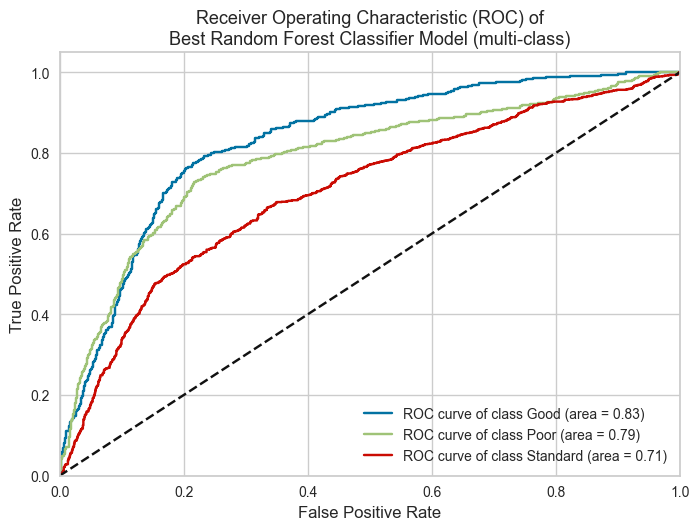

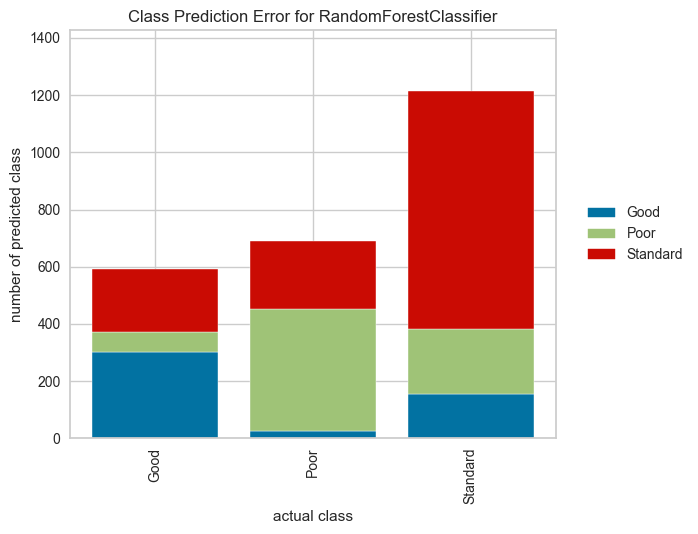

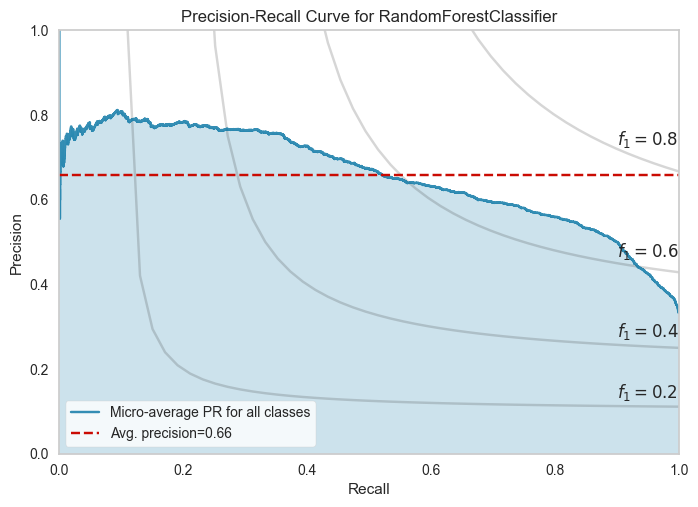

In [23]:
print(classification_report(y_test, grid_ranf.best_estimator_.predict(X_test),
                            target_names=target_names)
      )


auc_scores_ranf = multiclass_roc_auc_score_and_plot(grid_ranf.best_estimator_,
                                                   X_test, y_test,
                                                   model_name='Best Random Forest Classifier')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_ranf.best_estimator_,
                            is_fitted = True);

precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_ranf.best_estimator_,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Below I use the GridSearchCV on **Gradient Boosting Classifier** Pipeline:

In [24]:
gbc_params = {'estimator__learning_rate':[0.1, 1],
               'estimator__n_estimators':[10, 100],
               'estimator__criterion':['friedman_mse', 'squared_error'], # commented to reduce the dimensions of param_grid
               'estimator__ccp_alpha': [0.0, 0.05, 0.2],
               'estimator__max_features':['sqrt', 'log2'],
               'estimator__max_depth':[3, 10, 20]
               }

grid_gbc = \
    GridSearchCV(estimator= model_gbc,
                 param_grid= gbc_params,
                 scoring= score_metric_used,
                 return_train_score= True,
                 n_jobs = 4
                 ).fit(X_train, y_train)

And I plot/export the metrics below:

              precision    recall  f1-score   support

        Good       0.51      0.52      0.52       483
        Poor       0.62      0.57      0.60       720
    Standard       0.65      0.68      0.66      1297

    accuracy                           0.62      2500
   macro avg       0.60      0.59      0.59      2500
weighted avg       0.62      0.62      0.62      2500


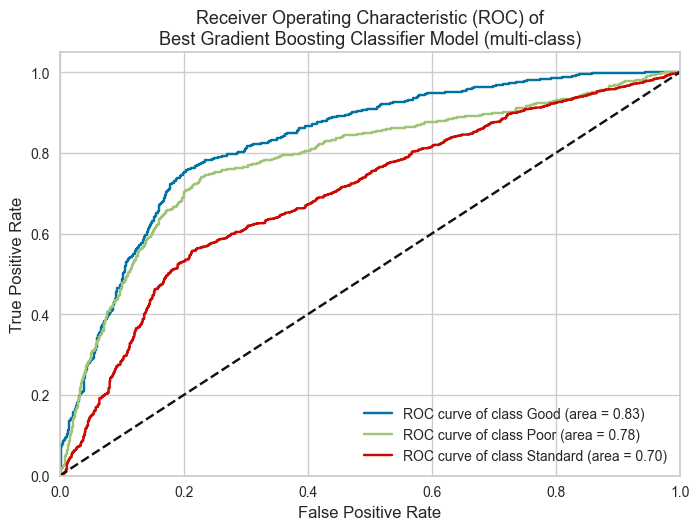

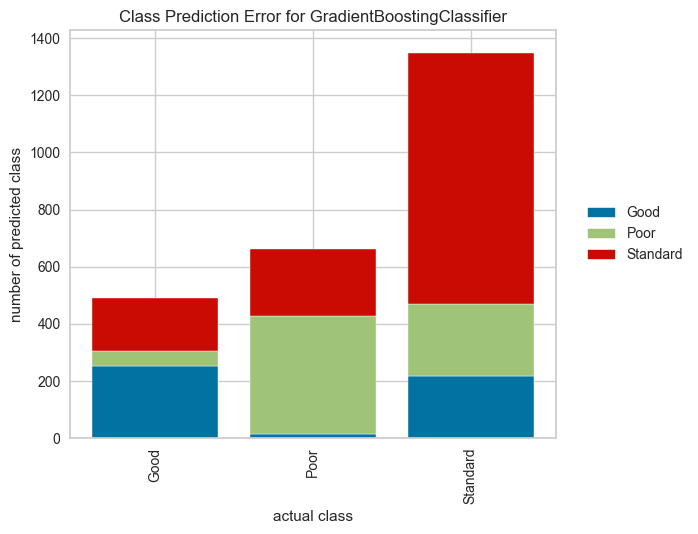

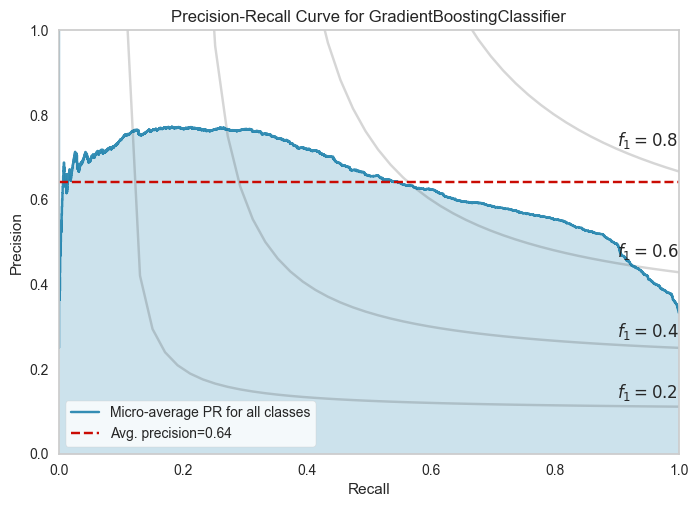

In [25]:
print(classification_report(y_test, grid_gbc.best_estimator_.predict(X_test),
                            target_names=target_names)
      )


auc_scores_gbc = multiclass_roc_auc_score_and_plot(grid_gbc.best_estimator_,
                                                    X_test, y_test,
                                                    model_name='Best Gradient Boosting Classifier')


class_prediction_error_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_gbc.best_estimator_,
                            is_fitted = True);

precision_recall_curve_plot(X_train, y_train, X_test, y_test,
                            estimator = grid_gbc.best_estimator_,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

Random Forest and Gradient Boosting Classifiers show the best overall results. Below, the results of the optimised / tuned models are demonstrated:

In [36]:
grid_models = \
[grid_lr,
grid_knn,
grid_dtr,
grid_svm,
grid_ranf,
grid_gbc]



model_names = \
['Logistic Regression',
 'KNN Classifier',
 'Decision Tree Classifier',
 'SVM Classifier',
 'Random Forest Classifier',
 'Gradient Boosting Classifier']


df_metrics = \
all_models_metrics(grid_models = grid_models,
                   model_names = model_names,
                   X_train = X_train, 
                   X_test = X_test,
                   y_train = y_train,
                   y_test = y_test)

In [37]:
df_metrics

,training_time,train_accuracy,test_accuracy,recall micro-average,precision micro-average,f1_score micro-average
Logistic Regression,0.056436,0.5620,0.5636,0.5636,0.5636,0.5636
KNN Classifier,0.042627,1.0000,0.6088,0.6088,0.6088,0.6088
Decision Tree Classifier,0.039694,0.5987,0.6096,0.6096,0.6096,0.6096
SVM Classifier,12.736677,0.6036,0.6040,0.6040,0.6040,0.6040
Random Forest Classifier,5.437860,0.7466,0.6244,0.6244,0.6244,0.6244
Gradient Boosting Classifier,2.257764,0.6472,0.6176,0.6176,0.6176,0.6176


According to the above results and ROC curves (AUC scores):
- Random Forests and Gradient Boosting Classifiers are promising (in terms of f1-score).
- As a result I will try to increase the input data to increase the models' performance.

Below I will insert all the observation (100k) to the models. Furthermore, I will add more features, specifically:
- Num_Bank_Accounts
- Num_of_Loan
- Changed_Credit_Limit
Will be added. The decision on this addition was based on the correlations heatmap.

#### Increasing datasets dimension

In [52]:
included_features_v2 = \
    ['Customer_ID',
     'Age',
     'Annual_Income',
     'Outstanding_Debt',
     'Total_EMI_per_month',
     'Delay_from_due_date',
     'Num_of_Delayed_Payment',
     'Credit_Utilization_Ratio',
     'Payment_Behaviour',
     'Credit_Mix',
     'Payment_of_Min_Amount',
     'Occupation',
     'Num_Bank_Accounts', #newly added
     'Num_of_Loan', #newly added
     'Changed_Credit_Limit', #newly added
     'Credit_Score']


data_v2 = pd.read_csv('data_clean/clean_dataset.csv')

X_v2 = data_v2[included_features_v2].drop(columns=['Customer_ID', 'Credit_Score'])
y_v2 = data_v2['Credit_Score']

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = \
    train_test_split(X_v2, y_v2,
                     random_state=42,
                     test_size=0.2,
                     stratify=y_v2)

target_names = ['Good', 'Poor', 'Standard'] # needed for classification report

#check
X_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  float64
 1   Annual_Income             100000 non-null  float64
 2   Outstanding_Debt          100000 non-null  float64
 3   Total_EMI_per_month       100000 non-null  float64
 4   Delay_from_due_date       100000 non-null  float64
 5   Num_of_Delayed_Payment    100000 non-null  float64
 6   Credit_Utilization_Ratio  100000 non-null  float64
 7   Payment_Behaviour         100000 non-null  object 
 8   Credit_Mix                100000 non-null  object 
 9   Payment_of_Min_Amount     100000 non-null  object 
 10  Occupation                100000 non-null  object 
 11  Num_Bank_Accounts         100000 non-null  float64
 12  Num_of_Loan               100000 non-null  int64  
 13  Changed_Credit_Limit      100000 non-null  fl

#### Creating, training and evaluating the new models (Random Forests and Gradient Boosting Classifiers)

              precision    recall  f1-score   support

        Good       0.73      0.75      0.74      3566
        Poor       0.77      0.80      0.78      5799
    Standard       0.81      0.79      0.80     10635

    accuracy                           0.78     20000
   macro avg       0.77      0.78      0.77     20000
weighted avg       0.78      0.78      0.78     20000


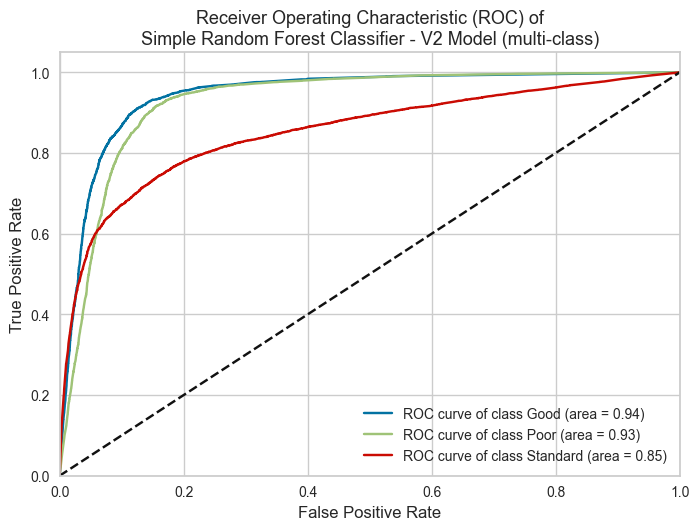

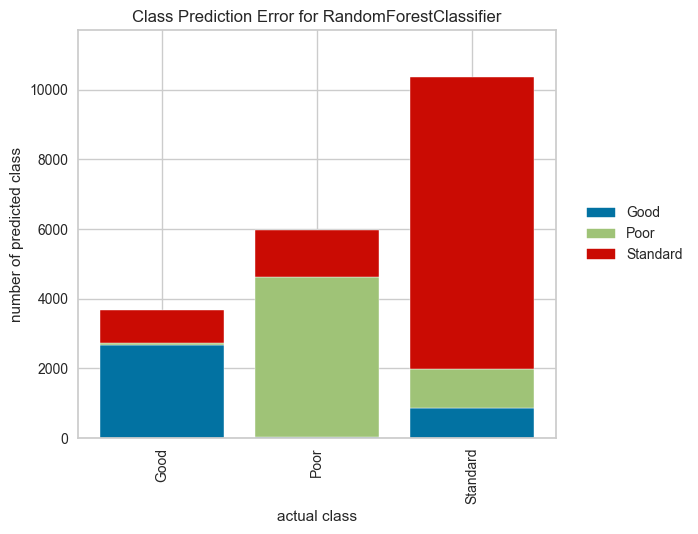

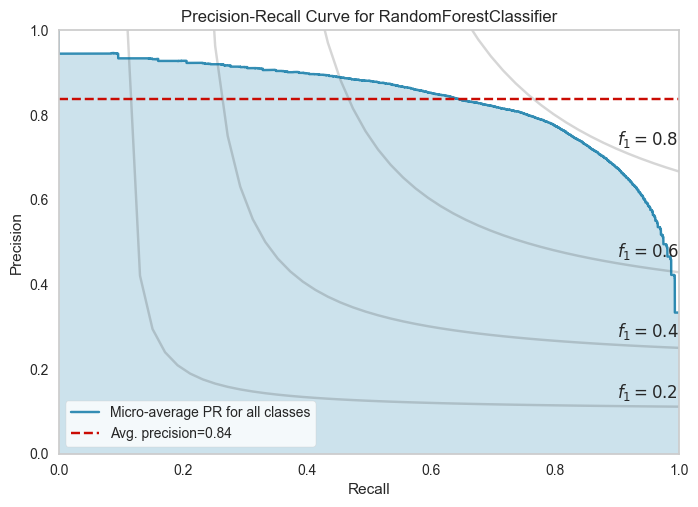

In [53]:
model_ranf_v2 = \
    Pipeline([
        ('preprocessor',pr_ord), # it uses tree models, so I do not use One Hot Encoding
        ('estimator', RandomForestClassifier(random_state= 42, oob_score = False) )
    ])

model_ranf_v2.fit(X_train_v2, y_train_v2)


print(classification_report(y_test_v2, model_ranf_v2.predict(X_test_v2),
                            target_names= target_names))

auc_scores_simple_ranf_v2 = multiclass_roc_auc_score_and_plot(model_ranf_v2,
                                                           X_test_v2, y_test_v2,
                                                           model_name='Simple Random Forest Classifier - V2')


class_prediction_error_plot(X_train_v2, y_train_v2, X_test_v2, y_test_v2,
                            estimator = model_ranf_v2,
                            is_fitted = True);



precision_recall_curve_plot(X_train_v2, y_train_v2, X_test_v2, y_test_v2,
                            estimator = model_ranf_v2,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

The above graphs demonstrate excellent results. I should also investigate Gradient Boosting Classifier.

              precision    recall  f1-score   support

        Good       0.52      0.80      0.63      3566
        Poor       0.67      0.67      0.67      5799
    Standard       0.79      0.66      0.72     10635

    accuracy                           0.69     20000
   macro avg       0.66      0.71      0.67     20000
weighted avg       0.71      0.69      0.69     20000


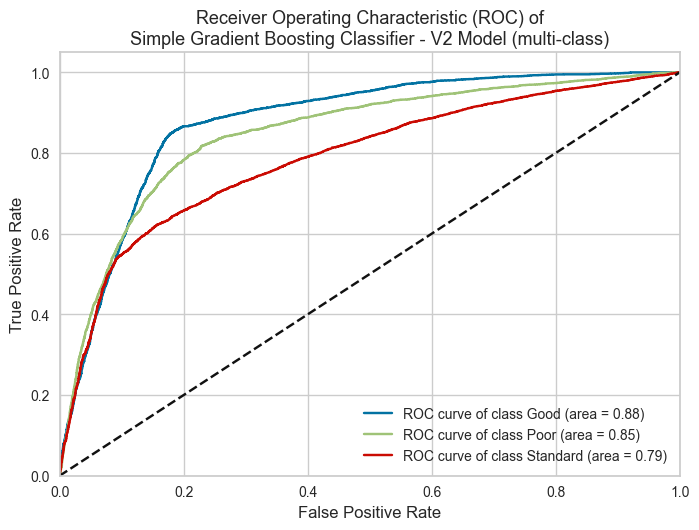

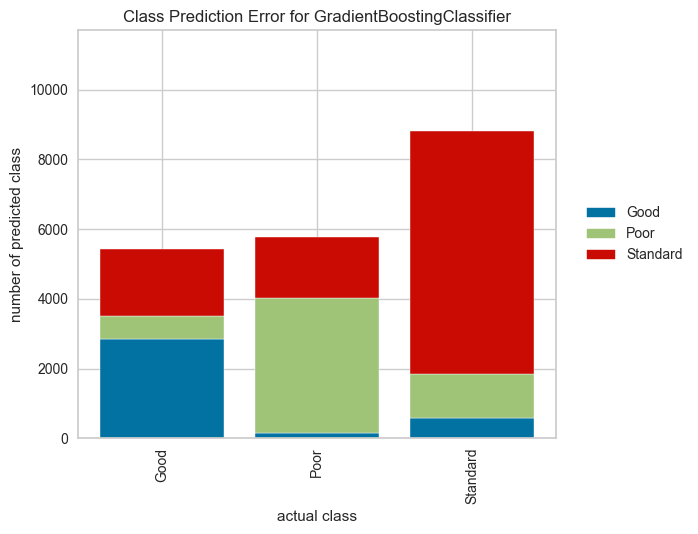

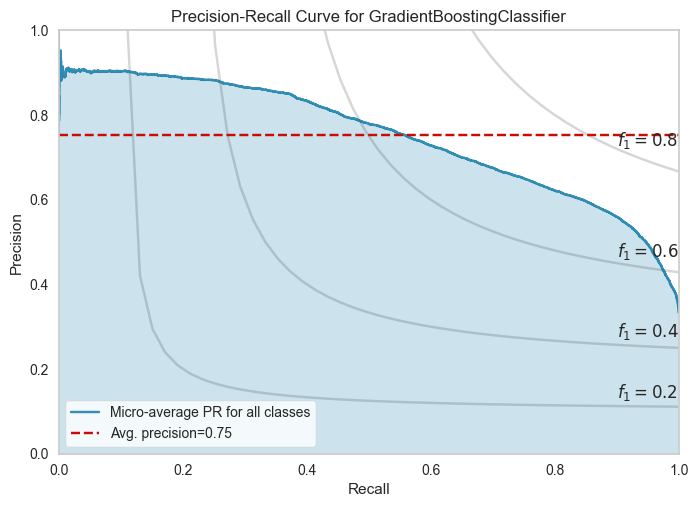

In [54]:
model_gbc_v2 = \
    Pipeline([
        ('preprocessor',pr_ord), # it uses tree models, so I do not use One Hot Encoding
        ('estimator', GradientBoostingClassifier(random_state= 42) )
    ])

model_gbc_v2.fit(X_train_v2, y_train_v2)


print(classification_report(y_test_v2, model_gbc_v2.predict(X_test_v2),
                            target_names= target_names))

auc_scores_simple_gbc_v2 = multiclass_roc_auc_score_and_plot(model_gbc_v2,
                                                          X_test_v2, y_test_v2,
                                                          model_name= 'Simple Gradient Boosting Classifier - V2')


class_prediction_error_plot(X_train_v2, y_train_v2, X_test_v2, y_test_v2,
                            estimator = model_gbc_v2,
                            is_fitted = True);



precision_recall_curve_plot(X_train_v2, y_train_v2, X_test_v2, y_test_v2,
                            estimator = model_gbc_v2,
                            line_per_class = False,
                            is_fitted = False,
                            plot_f1_curves=True,);

I will try to fine-tune the models through the GridSearchCV algorithm.
**Important Note** - Due to computational constraints of my local machine: 
- I will construct a parameters grid containing only three hyperparameters of the models.
- I will use a 3-fold cross validation during the grid searching (default is 5)

Creating the Random Forest Classifier - V2 using the GridSearchCV:

In [55]:
ranf_params_v2 = {'estimator__n_estimators': [50, 100, 150, 200],
               'estimator__criterion': ['gini', 'entropy'],
                'estimator__min_impurity_decrease':[0.0, 0.4]
               #'estimator__max_depth': [None, 20, 30] #commented to reduce the dimensions of params_grid
               }

grid_ranf_v2 = \
    GridSearchCV(estimator=model_ranf_v2,
                 param_grid=ranf_params_v2,
                 scoring=score_metric_used,
                 return_train_score=True,
                 n_jobs=4,
                 cv = 3
                 ).fit(X_train_v2, y_train_v2)

# check:
grid_ranf_v2.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Age', 'Annual_Income',
                                                   'Outstanding_Debt',
                                                   'Total_EMI_per_month',
                                                   'Delay_from_due_date',
                                                   'Num_of_Delayed_Payment']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Credit_Mix',
                                                   'Payment_of_Min_Amount'])])),
                ('estimator',
                 RandomForestClassifier(n_estimators=150, random_state=42))])

And plotting its results:

              precision    recall  f1-score   support

        Good       0.73      0.75      0.74      3566
        Poor       0.77      0.80      0.78      5799
    Standard       0.81      0.79      0.80     10635

    accuracy                           0.78     20000
   macro avg       0.77      0.78      0.77     20000
weighted avg       0.78      0.78      0.78     20000


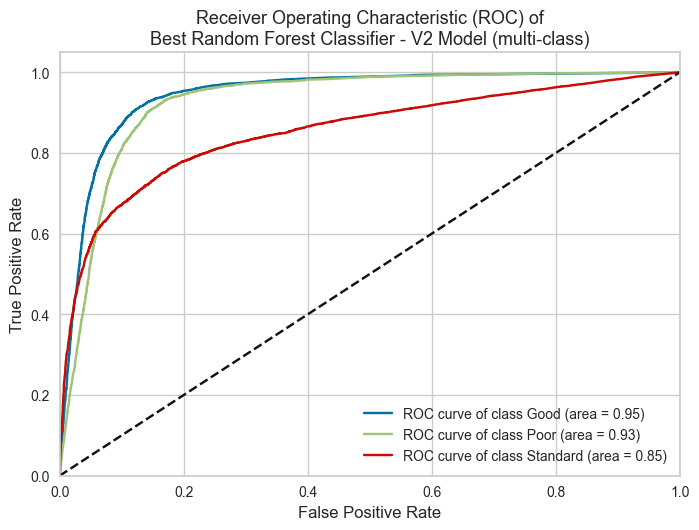

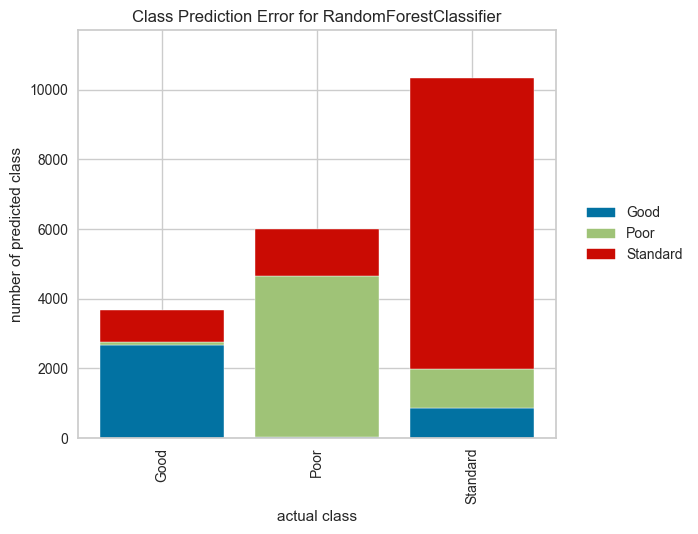

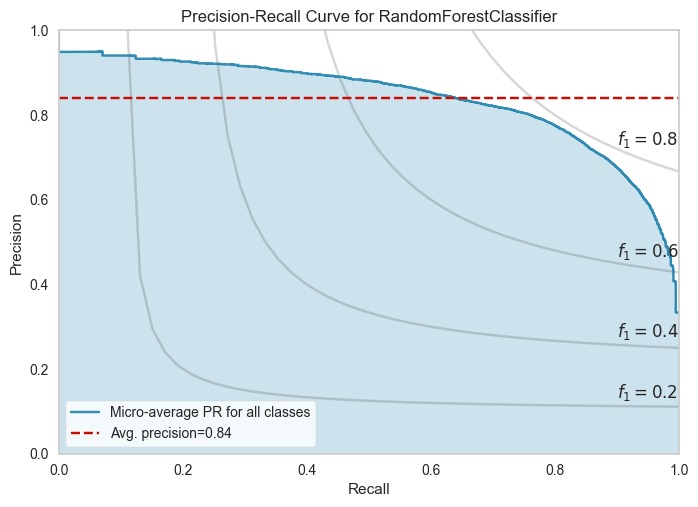

In [56]:
print(classification_report(y_test_v2, grid_ranf_v2.best_estimator_.predict(X_test_v2),
                            target_names=target_names)
      )

auc_scores_ranf_v2_2 = multiclass_roc_auc_score_and_plot(grid_ranf_v2.best_estimator_,
                                                    X_test_v2, y_test_v2,
                                                    model_name='Best Random Forest Classifier - V2')

class_prediction_error_plot(X_train_v2, y_train_v2, X_test_v2, y_test_v2,
                            estimator=grid_ranf_v2.best_estimator_,
                            is_fitted=True);

precision_recall_curve_plot(X_train_v2, y_train_v2, X_test_v2, y_test_v2,
                            estimator=grid_ranf_v2.best_estimator_,
                            line_per_class=False,
                            is_fitted=False,
                            plot_f1_curves=True, );

Creating the Gradient Boosting Classifier - V2 using the GridSearchCV:

In [57]:
gbc_params_v2 = {'estimator__learning_rate':[0.1, 1],
              'estimator__n_estimators':[50, 100, 150],
              'estimator__criterion':['friedman_mse', 'squared_error']
              }

grid_gbc_v2 = \
    GridSearchCV(estimator= model_gbc_v2,
                 param_grid= gbc_params_v2,
                 scoring= score_metric_used,
                 return_train_score= True,
                 n_jobs = 4,
                 cv = 3
                 ).fit(X_train_v2, y_train_v2)

grid_gbc_v2.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Age', 'Annual_Income',
                                                   'Outstanding_Debt',
                                                   'Total_EMI_per_month',
                                                   'Delay_from_due_date',
                                                   'Num_of_Delayed_Payment']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Credit_Mix',
                                                   'Payment_of_Min_Amount'])])),
                ('estimator',
                 GradientBoostingClassifier(criterion='squared_error',
                                            learning_rate=1, n_estimators=150,
                                            random_state=42))])

And plotting its results:

              precision    recall  f1-score   support

        Good       0.65      0.72      0.68      3566
        Poor       0.73      0.73      0.73      5799
    Standard       0.78      0.75      0.77     10635

    accuracy                           0.74     20000
   macro avg       0.72      0.73      0.73     20000
weighted avg       0.74      0.74      0.74     20000


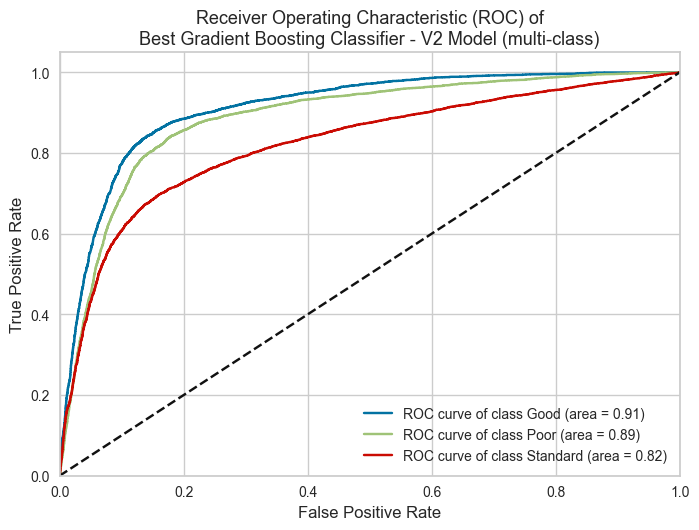

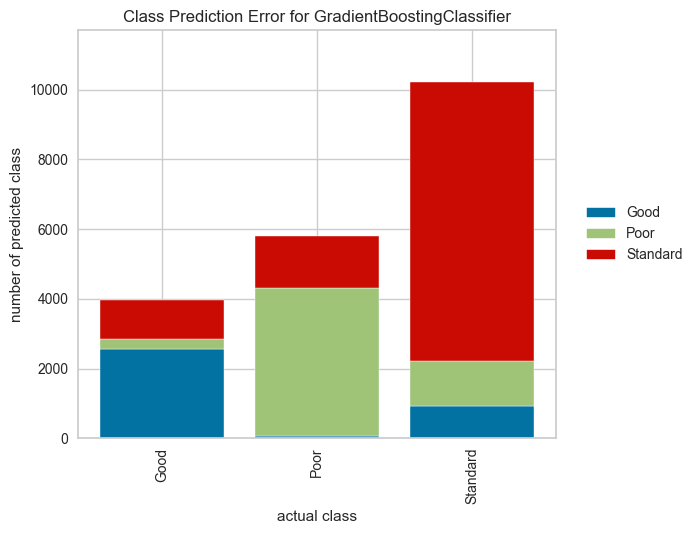

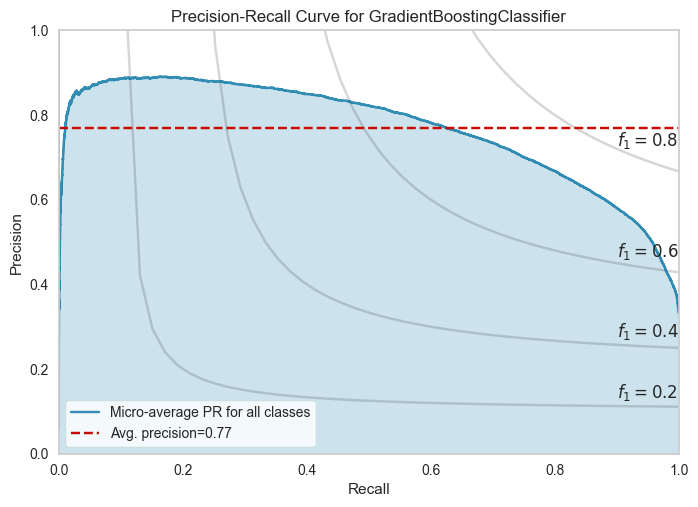

In [58]:
print(classification_report(y_test_v2, grid_gbc_v2.best_estimator_.predict(X_test_v2),
                            target_names=target_names)
      )

auc_scores_gbc_v2_2 = multiclass_roc_auc_score_and_plot(grid_gbc_v2.best_estimator_,
                                                         X_test_v2, y_test_v2,
                                                         model_name='Best Gradient Boosting Classifier - V2')

class_prediction_error_plot(X_train_v2, y_train_v2, X_test_v2, y_test_v2,
                            estimator=grid_gbc_v2.best_estimator_,
                            is_fitted=True);

precision_recall_curve_plot(X_train_v2, y_train_v2, X_test_v2, y_test_v2,
                            estimator=grid_gbc_v2.best_estimator_,
                            line_per_class=False,
                            is_fitted=False,
                            plot_f1_curves=True, );

In [63]:
grid_models_v2 = \
    [grid_ranf_v2,
     grid_gbc_v2]

model_names_v2 = \
    ['Random Forest Classifier - V2',
     'Gradient Boost Classifier - V2']


df_metrics_v2 = \
    all_models_metrics(grid_models = grid_models_v2,
                       model_names = model_names_v2,
                       X_train = X_train_v2,
                       X_test = X_test_v2,
                       y_train = y_train_v2,
                       y_test = y_test_v2)

df_metrics_v2

,training_time,train_accuracy,test_accuracy,recall micro-average,precision micro-average,f1_score micro-average
Random Forest Classifier - V2,16.372568,0.948263,0.78390,0.78390,0.78390,0.78390
Gradient Boost Classifier - V2,35.470828,0.778950,0.73955,0.73955,0.73955,0.73955


#### Concluding - Results

#### Next step reccomendations

In [60]:
print('Notebook runs without errors - End of Notebook 3')

Notebook runs without errors
